<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/master/evansetal/EvansEtAlReplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install gsw

     |████████████████████████████████| 2.4MB 5.3MB/s 


In [3]:
#Download the Falkor data

!wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/Microbial_Mysteries/bottle_data.flat0? -O falkor_data.tsv
!wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/ETNP_ParticleOmics/bottle.flat0?Cruise=RR1804 -O rr_data.tsv

--2021-04-01 08:58:23--  http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/Microbial_Mysteries/bottle_data.flat0?
Resolving dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)... 128.128.181.50
Connecting to dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘falkor_data.tsv’

falkor_data.tsv         [  <=>               ] 226.36K   748KB/s    in 0.3s    

2021-04-01 08:58:24 (748 KB/s) - ‘falkor_data.tsv’ saved [231792]

--2021-04-01 08:58:24--  http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/ETNP_ParticleOmics/bottle.flat0?Cruise=RR1804
Resolving dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)... 128.128.181.50
Connecting to dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘rr_data.tsv’

rr_data.tsv             [  <=>               ] 255.39K   730KB/s    in 0.3s    

2021-0

In [48]:
import pandas as pd
import gsw
import numpy as np

#"Conservative temperature, absolute salinity, oxygen, phosphate, and spiciness were used for this OMPA study"

def process_falkor():
  df = pd.read_csv("falkor_data.tsv", delim_whitespace=True, header=0,
                   na_values=-999)
  df["lat"] = df["LATITUDE"]
  df["lon"] = df["LONGITUDE"]
  df["pressure"] = df["CTDPRS"]
  df["Depth"] = -gsw.z_from_p(p=df["pressure"], lat=df["lat"])
  df["absolute_salinity"] = gsw.SA_from_SP(
                              SP=df["CTDSAL"],
                              p=df["pressure"],
                              lon=df["lon"],
                              lat=df["lat"])
  df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=df["CTDTMP"],
                                          p=df["pressure"])
  df["oxygen"] = df["CTDOXY"]
  df["phosphate"] = np.nan_to_num(df["PHSPHT"], nan=0.0)
  df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                   CT=df["conservative_temp"])
  df["nitrate"] = np.nan_to_num(df["NOx"] - df["NITRIT_BabLab"], nan=0.0) #q: is NOx better to use?
  df["sig0"] = gsw.rho(SA=df["absolute_salinity"],
                       CT=df["conservative_temp"], p=0) - 1000
  return df

def process_rr():
  df = pd.read_csv("rr_data.tsv", delim_whitespace=True, header=0,
                   na_values="nd")
  df["lat"] = df["Latitude"]
  df["lon"] = df["Longitude"]
  df["pressure"] = gsw.p_from_z(z=-df["Depth"], lat=df["lat"])
  df["absolute_salinity"] = gsw.SA_from_SP(
                              SP=0.5*(df["Sal0"] + df["Sal1"]),
                              p=df["pressure"],
                              lon=df["lon"],
                              lat=df["lat"])
  df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=0.5*(df["T0"] + df["T1"]),
                                          p=df["pressure"])
  df["oxygen"] = 0.5*(df["Sbeox_0"] + df["Sbeox_1"])
  df["phosphate"] = np.nan_to_num(x=df["PO4"], nan=0.0)
  df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                   CT=df["conservative_temp"])
  df["nitrate"] = np.nan_to_num(x=df["NO3"], nan=0.0)
  #(I am not sure why the Sigma_0 column of the original table gives a different
  # answer - rounding errors?)
  df["sig0"] = gsw.rho(SA=df["absolute_salinity"],
                       CT=df["conservative_temp"], p=0) - 1000
  return df

falkor_df = process_falkor()
rr_df = process_rr()


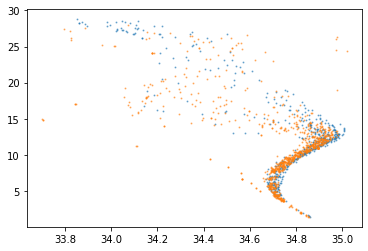

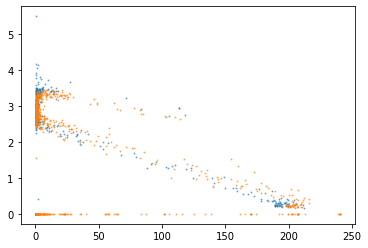

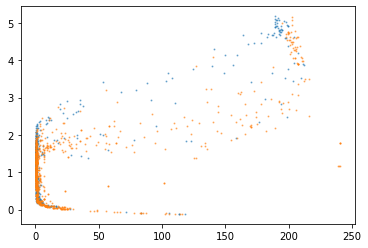

In [49]:
#sanity check by replotting some figures from Fig 3
from matplotlib import pyplot as plt
plt.scatter(falkor_df["absolute_salinity"],
            falkor_df["conservative_temp"], s=1, alpha=0.5)
plt.scatter(rr_df["absolute_salinity"],
            rr_df["conservative_temp"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["phosphate"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["phosphate"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["spiciness"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["spiciness"], s=1, alpha=0.5)
plt.show()

In [32]:
rr_df

,Cruise,Station,Date,Cast,CTD_btl,Longitude,Latitude,Depth,Sal0,Sal1,T0,T1,Sigma_0,Sigma_11,Sbeox_0,Sbeox_1,Sbeox_pcnt,Fluorescence,Beam_Attn,Beam_Trans,Par,pH,PO4,SiOH_4,NO3,NO2,NH4,lat,lon,pressure,absolute_salinity,conservative_temp,oxygen,phosphate,nitrate,sig0
0,RR1804,0,2018-03-28,1,1.0,-114.65566,26.95928,798.899,34.4705,34.4689,5.0323,5.0325,27.2594,27.2580,8.828113,8.829,2.863,0.0683,12.3413,4.5715,0.0638,7.573,NaN,NaN,NaN,NaN,NaN,26.95928,-114.65566,805.746848,34.644707,4.965797,8.828557,0.0,0.0,27.269146
1,RR1804,0,2018-03-28,1,2.0,-114.65566,26.95928,799.602,34.4707,34.4690,5.0312,5.0317,27.2597,27.2582,8.785522,8.785,2.849,0.0681,12.3415,4.5713,0.0628,NaN,NaN,NaN,NaN,NaN,NaN,26.95928,-114.65566,806.457245,34.644866,4.964789,8.785261,0.0,0.0,27.269386
2,RR1804,0,2018-03-28,1,3.0,-114.65570,26.95930,698.582,34.4546,34.4526,5.5027,5.5037,27.1906,27.1889,6.464853,6.464,2.119,0.0690,12.3425,4.5701,0.0586,7.549,NaN,NaN,NaN,NaN,NaN,26.95930,-114.65570,704.398939,34.627447,5.442993,6.464426,0.0,0.0,27.199433
3,RR1804,0,2018-03-28,1,4.0,-114.65570,26.95932,699.468,34.4545,34.4523,5.5087,5.5124,27.1898,27.1876,6.467903,6.469,2.121,0.0695,12.3426,4.5700,0.0568,NaN,NaN,NaN,NaN,NaN,NaN,26.95932,-114.65570,705.293831,34.627257,5.450223,6.468452,0.0,0.0,27.198413
4,RR1804,0,2018-03-28,1,5.0,-114.65562,26.95926,599.322,34.4354,34.4330,6.1508,6.1509,27.0941,27.0923,5.230177,5.229,1.740,0.0695,12.3416,4.5712,0.0577,7.559,NaN,NaN,NaN,NaN,NaN,26.95926,-114.65562,604.167076,34.606740,6.096759,5.229589,0.0,0.0,27.102071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,RR1804,31,2018-04-13,41,21.0,-105.46538,19.58332,299.471,34.7287,34.7300,11.0319,11.0327,26.5653,26.5653,0.992387,0.994,0.369,0.0757,12.3424,4.5702,0.0507,NaN,NaN,NaN,NaN,NaN,NaN,19.58332,-105.46538,301.523561,34.897689,10.989677,0.993193,0.0,0.0,26.571799
929,RR1804,31,2018-04-13,41,22.0,-105.46538,19.58332,298.706,34.7295,34.7305,11.0471,11.0470,26.5631,26.5631,0.980213,0.981,0.365,0.0757,12.3435,4.5689,0.0507,NaN,NaN,NaN,NaN,NaN,NaN,19.58332,-105.46538,300.752758,34.898336,11.004480,0.980606,0.0,0.0,26.569625
930,RR1804,31,2018-04-13,41,23.0,-105.46538,19.58332,298.868,34.7294,34.7302,11.0406,11.0410,26.5642,26.5642,1.047182,1.046,0.389,0.0765,12.3427,4.5699,0.0507,NaN,NaN,NaN,NaN,NaN,NaN,19.58332,-105.46538,300.915987,34.898136,10.998226,1.046591,0.0,0.0,26.570600
931,RR1804,31,2018-04-13,41,24.0,-105.46538,19.58332,299.259,34.7291,34.7300,11.0360,11.0364,26.5648,26.5648,0.952814,0.954,0.355,0.0752,12.3426,4.5700,0.0507,NaN,NaN,NaN,NaN,NaN,NaN,19.58332,-105.46538,301.309953,34.897888,10.993592,0.953407,0.0,0.0,26.571246


In [33]:
falkor_df

,CRUISEID,EXPOCODE,STNNBR,CASTNO,SAMPNO,DATE,TIME,ISO_DateTime_UTC,LATITUDE,LONGITUDE,BOTTOM_DEPTH,CTDPRS,CTDTMP,CTDSAL,CTDS_FLAG_W,CTDOXY,CTDOXY_FLAG_W,FLOR,FLOR_FLAG_W,NOx,NOx_FLAG_W,NOx_stdev,NOx_STD_FLAG_W,NITRIT_BabLab,NITRIT_FLAG_W,PHSPHT,PHSPHT_FLAG_W,NH4,NH4_FLAG_W,PH_TOT,PH_TOT_FLAG_W,PH_TEMP,TA,TA_FLAG_W,lat,lon,pressure,Depth,absolute_salinity,conservative_temp,oxygen,phosphate,spiciness,nitrate,sig0
0,FK180624,33FA20180624,1,1,1,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99756,-101.99646,3000,1007.273,4.5197,34.5597,2,10.023,2,0.0305,2,42.624000,6,0.007000,2,0.000000,2,3.713901,2,0.000000,2,7.353685,2,25,2365.73,2,13.99756,-101.99646,1007.273,999.007122,34.734311,4.438064,10.023,3.713901,0.104726,42.624000,27.398862
1,FK180624,33FA20180624,1,1,2,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99696,-101.99638,3000,761.228,5.6446,34.5511,2,2.048,2,0.0289,2,39.711000,6,1.105000,2,0.000000,6,3.670797,6,0.000000,6,7.337197,2,25,2317.43,3,13.99696,-101.99638,761.228,755.425321,34.723428,5.577083,2.048,3.670797,0.241299,39.711000,27.258623
2,FK180624,33FA20180624,1,1,3,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99666,-101.99637,3000,674.359,6.2323,34.5625,2,1.936,2,0.0216,2,37.249000,6,0.925000,2,0.000000,2,3.439116,2,0.000000,2,7.338867,2,25,2341.66,2,13.99666,-101.99637,674.359,669.357886,34.734016,6.169364,1.936,3.439116,0.329904,37.249000,27.192579
3,FK180624,33FA20180624,1,1,4,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99634,-101.99632,3000,575.667,6.9636,34.5694,2,1.906,2,0.0180,2,33.850000,6,0.195000,2,0.363868,2,3.390625,2,0.000000,2,7.348678,2,25,2336.83,2,13.99634,-101.99632,575.667,571.533231,34.739875,6.906517,1.906,3.390625,0.440519,33.486132,27.099100
4,FK180624,33FA20180624,1,1,5,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99590,-101.99632,3000,475.147,8.1096,34.5930,2,1.814,2,0.0238,2,27.698000,6,0.024000,2,0.495643,2,4.155711,2,0.000000,2,7.363535,6,25,2325.23,2,13.99590,-101.99632,475.147,471.849141,34.762251,8.057770,1.814,4.155711,0.634736,27.202357,26.951400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,FK180624,33FA20180624,19,1,20,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99955,-119.00078,4000,90.737,16.7505,33.9801,2,157.980,2,0.8951,2,3.554591,6,1.099262,2,0.128019,2,0.729715,2,0.014216,2,7.812985,2,25,2261.35,2,17.99955,-119.00078,90.737,90.173334,34.141537,16.753791,157.980,0.729715,1.929561,3.426572,24.798823
523,FK180624,33FA20180624,19,1,21,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99953,-119.00073,4000,80.813,18.9031,33.9934,2,198.824,2,1.2204,2,2.780000,2,-999.000000,9,0.063903,2,0.421936,2,0.013410,2,7.891521,6,25,2269.19,2,17.99953,-119.00073,80.813,80.312916,34.154743,18.910799,198.824,0.421936,2.469533,2.716097,24.285130
524,FK180624,33FA20180624,19,1,22,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99948,-119.00075,4000,49.845,23.1536,34.3255,2,211.656,2,0.0950,2,0.170000,2,-999.000000,9,0.000000,2,0.170118,2,0.000000,2,8.006897,2,25,2285.60,2,17.99948,-119.00075,49.845,49.540272,34.488058,23.164151,211.656,0.170118,3.863681,0.170000,23.384316
525,FK180624,33FA20180624,19,1,23,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99944,-119.00076,4000,28.982,24.1989,34.3532,2,207.283,2,0.0388,2,0.430000,2,-999.000000,9,0.000000,2,0.203693,2,0.000000,2,8.019350,2,25,2290.30,2,17.99944,-119.00076,28.982,28.806277,34.515713,24.215060,207.283,0.203693,4.185726,0.430000,23.097577
